<a href="https://colab.research.google.com/github/syphax/solar-data/blob/main/nb/Clean_GMP_Solar_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

This notebook pre-processes raw downloads from https://greenmountainpower.com/account/usage and produces one cleansed file, suitable for further analysis by the `Solar Viz` notebook.

To run this script, you need access to Google Drive, and you need to copy the data from https://github.com/syphax/solar-data/tree/main/data to `/My Drive/Data/Solar` (or edit the path variable in the 2nd code block to point somewhere else).

__Currently, this script only works when run on Google Colab.__

_TODO: Load the data directly from the GitHub repo._



# Setup

In [1]:
import os
import re

from datetime import datetime

import numpy as np
import pandas as pd
import pytz

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# You can of course edit this to taste:

path = '/content/drive/MyDrive/Data/Solar/GMP'

In [3]:
# This will require you to click through a couple windows to
# give permission to access your GDrive.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

This script preps data that was downloaded from [Green Mountain Power's website](https://greenmountainpower.com/account/usage/).

GMP has an excellent UI for reporting usage, and provides downloadable data in 15 minute increments (either CSV or Green Button XML). *Unfortunately* it only supports manual data downloads in 15 day (max) chunks.  
*Fortunately* it only takes a couple minutes to download several months of data. The manual downloads are just easy enough that I haven't bothered to automate the process.

Fields in the CSV downloads are:
* `ServiceAgreement`: Account info. Format is `Account Holder / Service / Service Acronym / Account Start Date / Account Status`
* `IntervalStart`: Timestamp; format is `yyyy-MM-dd-hh:mm:ss`
* `IntervalEnd`: Same, 15 minutes later. Redundant but explicit!
* `Quantity`: Amount of electricity generated
* `UnitOfMeasure` `kWh`. I love that they have an explicit UoM field!


In [4]:
#path = '/content/drive/MyDrive/Data/Solar/'

raw_input_files = os.path.join(path, 'UsageData*.csv')
joined_input_file = os.path.join(path, 'full_dataset.csv')


In [5]:
# This should list the data files that you copied from https://github.com/syphax/solar-data/tree/main/data

!ls $path

bak				 UsageData_2022-03-13_7Days.csv   UsageData_2023-02-01_14Days.csv
full_dataset.csv		 UsageData_2022-03-16_14Days.csv  UsageData_2023-02-15_14Days.csv
UsageData_2021-05-23_14Days.csv  UsageData_2022-03-30_14Days.csv  UsageData_2023-03-01_14Days.csv
UsageData_2021-06-06_14Days.csv  UsageData_2022-04-13_14Days.csv  UsageData_2023-03-15_14Days.csv
UsageData_2021-06-20_14Days.csv  UsageData_2022-04-27_14Days.csv  UsageData_2023-03-29_14Days.csv
UsageData_2021-07-04_14Days.csv  UsageData_2022-05-11_14Days.csv  UsageData_2023-04-12_14Days.csv
UsageData_2021-07-18_14Days.csv  UsageData_2022-05-25_14Days.csv  UsageData_2023-04-26_14Days.csv
UsageData_2021-08-01_14Days.csv  UsageData_2022-06-08_14Days.csv  UsageData_2023-05-10_14Days.csv
UsageData_2021-08-15_14Days.csv  UsageData_2022-06-22_14Days.csv  UsageData_2023-05-24_14Days.csv
UsageData_2021-08-29_14Days.csv  UsageData_2022-07-06_14Days.csv  UsageData_2023-06-07_14Days.csv
UsageData_2021-09-12_14Days.csv  UsageData_2022-07-20_14Day

In [6]:
# This concatenates available data files. We will need to remove possible dupes, and check for completeness.

!cat $raw_input_files > $joined_input_file

In [7]:
df_energy_data_raw = pd.read_csv(joined_input_file)

# Check and Clean

In [8]:
# What fields are there?

df_energy_data_raw.dtypes

ServiceAgreement    object
IntervalStart       object
IntervalEnd         object
Quantity            object
UnitOfMeasure       object
dtype: object

In [9]:
# Remove duplicate header rows (from the concatenation)

df_energy_data_raw = df_energy_data_raw[df_energy_data_raw['Quantity'] != 'Quantity'].copy()

In [10]:
# Make a clean field for kWh values

df_energy_data_raw['kWh'] = 0

df_energy_data_raw['kWh'] = np.where(df_energy_data_raw['UnitOfMeasure'] == 'kWh', df_energy_data_raw['Quantity'], 0)
df_energy_data_raw['kWh'] = df_energy_data_raw['kWh'].astype(np.float64)

In [11]:
# Quick check of values in df:

df_energy_data_raw.groupby(['ServiceAgreement', 'UnitOfMeasure'], as_index=False).agg(cnt_records=('ServiceAgreement','count'),
                                                                                      unique_dt=('IntervalStart','nunique'),
                                                                                      kwh=('kWh','sum'))

,ServiceAgreement,UnitOfMeasure,cnt_records,unique_dt,kwh
0,ACCOUNT_OWNER / Group Generation Allocation - ...,kWh,8060,8060,1194.94
1,ACCOUNT_OWNER / Group Generation Allocation - ...,kWh,8060,8060,955.90
2,ACCOUNT_OWNER / Interconnected Generation Resi...,kWh,83232,81012,18179.50
3,ACCOUNT_OWNER / Residential Net Metering / N01...,kWh,83232,81012,5899.97
4,ACCOUNT_OWNER / Residential Net Metering / NGE...,kWh,100127,97903,17441.16
5,ACCOUNT_OWNER / Residential Water Heater / RE0...,kWh,91292,89072,4346.01


## Set up and correct timestamps

The timestamps in these files are in local time (discovered through inspection around the "spring forward" and "fall back" days)

To ensure that the timestamps are aligned consistently, we need to adjust for DST. Otherwise, we'll see funky inconsistencies when analyzing production by hour of day.

In the following block, we ensure that all timestamps are in EST. We choose EST because, for my main location of interest, solar noon is closer to EST noon than EDT noon (according to the [NOAA Solar Calculator](https://gml.noaa.gov/grad/solcalc/) ).

In [12]:
# Add date field for interval starts

fmt = '%Y-%m-%d-%H:%M:%S'
df_energy_data_raw['dt_start_raw'] = pd.to_datetime(df_energy_data_raw['IntervalStart'], format=fmt, errors='coerce')
df_energy_data_raw['dt_end_raw'] = pd.to_datetime(df_energy_data_raw['IntervalEnd'], format=fmt, errors='coerce')

In [13]:
# Convert to EST

from pytz import timezone

est = timezone('US/Eastern')

# Convert the datetime column to EST and correct for DST
# We use `ambiguous='NaT'` to clearly flag the records on the edge of DST
# We'll double-check that consumption and production are small in these times, so we can remove them
df_energy_data_raw['dt_start'] = df_energy_data_raw['dt_start_raw'].dt.tz_localize(est, ambiguous='NaT')
df_energy_data_raw['dt_end'] = df_energy_data_raw['dt_end_raw'].dt.tz_localize(est, ambiguous='NaT')


In [14]:
df_energy_data_raw[df_energy_data_raw['dt_start'].isna()].groupby('ServiceAgreement').agg({'UnitOfMeasure':'count', 'kWh':'sum'})

,UnitOfMeasure,kWh
ServiceAgreement,,
ACCOUNT_OWNER / Interconnected Generation Residential / INTC / 06-04-2021 12:00:00AM / Active,20,0.00
ACCOUNT_OWNER / Residential Net Metering / N01 / 06-04-2021 12:00:00AM / Active,20,1.11
ACCOUNT_OWNER / Residential Net Metering / NGEN / 06-04-2021 12:00:00AM / Active,28,0.00
ACCOUNT_OWNER / Residential Water Heater / RE03 / 06-04-2021 12:00:00AM / Active,20,1.40


In [15]:
# Assuming the above values are small (~ 1-2 kWh), drop them:

df_energy_data_raw = df_energy_data_raw[~df_energy_data_raw['dt_start'].isna()]

In [16]:
# Check totals again:

df_energy_data_raw.groupby('ServiceAgreement').agg({'UnitOfMeasure':'count', 'kWh':'sum'})

,UnitOfMeasure,kWh
ServiceAgreement,,
ACCOUNT_OWNER / Group Generation Allocation - Inter Residential USAGE (no $) / UINTC / 12-21-2023 12:00:00AM / Active,8060,1194.94
ACCOUNT_OWNER / Group Generation Allocation - Residential USAGE (no $) / U01N / 12-21-2023 12:00:00AM / Active,8060,955.90
ACCOUNT_OWNER / Interconnected Generation Residential / INTC / 06-04-2021 12:00:00AM / Active,83212,18179.50
ACCOUNT_OWNER / Residential Net Metering / N01 / 06-04-2021 12:00:00AM / Active,83212,5898.86
ACCOUNT_OWNER / Residential Net Metering / NGEN / 06-04-2021 12:00:00AM / Active,100099,17441.16
ACCOUNT_OWNER / Residential Water Heater / RE03 / 06-04-2021 12:00:00AM / Active,91272,4344.61


## Extract service level code

In [17]:
# Extract service level code

p = re.compile('.*/.*/(.*)/.*/.*')

sl = df_energy_data_raw['ServiceAgreement'].str.extract(p)

df_energy_data_raw['Service'] = sl[0].str.strip()


In [18]:
# Check for dupes

df_dupe_check = df_energy_data_raw.groupby(['Service', 'IntervalStart'], as_index=False).agg(cnt_dupes=('IntervalStart','count'))

df_dupe_check = df_dupe_check[df_dupe_check['cnt_dupes'] != 1]

df_dupe_records = df_energy_data_raw.merge(df_dupe_check, on=['Service', 'IntervalStart'], how='inner').sort_values(['IntervalStart', 'Service'])

In [19]:
df_dupe_records.groupby('dt_start').agg({'cnt_dupes':'sum'})

,cnt_dupes
dt_start,
2021-11-07 00:00:00-04:00,16
2021-11-07 00:15:00-04:00,16
2021-11-07 00:30:00-04:00,16
2021-11-07 00:45:00-04:00,16
2021-11-18 00:00:00-05:00,16
...,...
2023-06-20 22:45:00-04:00,16
2023-06-20 23:00:00-04:00,16
2023-06-20 23:15:00-04:00,16


In [20]:
display(df_dupe_records)

,ServiceAgreement,IntervalStart,IntervalEnd,Quantity,UnitOfMeasure,kWh,dt_start_raw,dt_end_raw,dt_start,dt_end,Service,cnt_dupes
24,ACCOUNT_OWNER / Interconnected Generation Resi...,2021-11-07-00:00:00,2021-11-07-00:15:00,0.0,kWh,0.00,2021-11-07 00:00:00,2021-11-07 00:15:00,2021-11-07 00:00:00-04:00,2021-11-07 00:15:00-04:00,INTC,2
25,ACCOUNT_OWNER / Interconnected Generation Resi...,2021-11-07-00:00:00,2021-11-07-00:15:00,0.0,kWh,0.00,2021-11-07 00:00:00,2021-11-07 00:15:00,2021-11-07 00:00:00-04:00,2021-11-07 00:15:00-04:00,INTC,2
8,ACCOUNT_OWNER / Residential Net Metering / N01...,2021-11-07-00:00:00,2021-11-07-00:15:00,0.06,kWh,0.06,2021-11-07 00:00:00,2021-11-07 00:15:00,2021-11-07 00:00:00-04:00,2021-11-07 00:15:00-04:00,N01,2
9,ACCOUNT_OWNER / Residential Net Metering / N01...,2021-11-07-00:00:00,2021-11-07-00:15:00,0.06,kWh,0.06,2021-11-07 00:00:00,2021-11-07 00:15:00,2021-11-07 00:00:00-04:00,2021-11-07 00:15:00-04:00,N01,2
0,ACCOUNT_OWNER / Residential Net Metering / NGE...,2021-11-07-00:00:00,2021-11-07-00:15:00,0.0,kWh,0.00,2021-11-07 00:00:00,2021-11-07 00:15:00,2021-11-07 00:00:00-04:00,2021-11-07 00:15:00-04:00,NGEN,2
...,...,...,...,...,...,...,...,...,...,...,...,...
12671,ACCOUNT_OWNER / Residential Net Metering / N01...,2023-06-20-23:45:00,2023-06-21-00:00:00,0.09,kWh,0.09,2023-06-20 23:45:00,2023-06-21 00:00:00,2023-06-20 23:45:00-04:00,2023-06-21 00:00:00-04:00,N01,2
10174,ACCOUNT_OWNER / Residential Net Metering / NGE...,2023-06-20-23:45:00,2023-06-21-00:00:00,0.0,kWh,0.00,2023-06-20 23:45:00,2023-06-21 00:00:00,2023-06-20 23:45:00-04:00,2023-06-21 00:00:00-04:00,NGEN,2
10175,ACCOUNT_OWNER / Residential Net Metering / NGE...,2023-06-20-23:45:00,2023-06-21-00:00:00,0.0,kWh,0.00,2023-06-20 23:45:00,2023-06-21 00:00:00,2023-06-20 23:45:00-04:00,2023-06-21 00:00:00-04:00,NGEN,2
15166,ACCOUNT_OWNER / Residential Water Heater / RE0...,2023-06-20-23:45:00,2023-06-21-00:00:00,1.1,kWh,1.10,2023-06-20 23:45:00,2023-06-21 00:00:00,2023-06-20 23:45:00-04:00,2023-06-21 00:00:00-04:00,RE03,2


As we've already dealt with the DST issue, we can safely drop duplicate records, which are likely due to overlapping extracts.

In [21]:
sh0 = df_energy_data_raw.shape

df_solar_data = df_energy_data_raw.copy()

sh0 = df_solar_data.shape

df_solar_data = df_solar_data.drop_duplicates()

sh1 = df_solar_data.shape

cnt_dupes = sh0[0] - sh1[0]

# Number of hours, as data is every 15 minutes:
cnt_unique_services = df_solar_data['Service'].nunique()

cnt_hours = sh1[0] / 4.0 / cnt_unique_services
cnt_years = cnt_hours / (365.25 * 24)

print("{:,} original entries. Removed {:,} duplicate entries; {:,} left.".format(sh0[0], cnt_dupes, sh1[0]))
print("{:,} hours of data ({:.2f} years).".format(cnt_hours, cnt_years))

373,915 original entries. Removed 8,832 duplicate entries; 365,083 left.
15,211.791666666666 hours of data (1.74 years).


In [22]:
# Drop ServiceAgreement (which contains some PID):

df_solar_data = df_solar_data.drop('ServiceAgreement', axis=1)

In [23]:
df_solar_data.sample(8)

,IntervalStart,IntervalEnd,Quantity,UnitOfMeasure,kWh,dt_start_raw,dt_end_raw,dt_start,dt_end,Service
277118,2023-05-02-02:30:00,2023-05-02-02:45:00,0.0,kWh,0.00,2023-05-02 02:30:00,2023-05-02 02:45:00,2023-05-02 02:30:00-04:00,2023-05-02 02:45:00-04:00,RE03
341,2021-05-26-13:15:00,2021-05-26-13:30:00,0.3,kWh,0.30,2021-05-26 13:15:00,2021-05-26 13:30:00,2021-05-26 13:15:00-04:00,2021-05-26 13:30:00-04:00,NGEN
342176,2024-01-04-15:15:00,2024-01-04-15:30:00,0.02,kWh,0.02,2024-01-04 15:15:00,2024-01-04 15:30:00,2024-01-04 15:15:00-05:00,2024-01-04 15:30:00-05:00,NGEN
31401,2021-08-06-01:00:00,2021-08-06-01:15:00,0.0,kWh,0.00,2021-08-06 01:00:00,2021-08-06 01:15:00,2021-08-06 01:00:00-04:00,2021-08-06 01:15:00-04:00,INTC
182915,2022-09-05-00:00:00,2022-09-05-00:15:00,0.0,kWh,0.00,2022-09-05 00:00:00,2022-09-05 00:15:00,2022-09-05 00:00:00-04:00,2022-09-05 00:15:00-04:00,NGEN
201302,2022-10-12-12:00:00,2022-10-12-12:15:00,0.0,kWh,0.00,2022-10-12 12:00:00,2022-10-12 12:15:00,2022-10-12 12:00:00-04:00,2022-10-12 12:15:00-04:00,RE03
256818,2023-03-05-15:30:00,2023-03-05-15:45:00,0.08,kWh,0.08,2023-03-05 15:30:00,2023-03-05 15:45:00,2023-03-05 15:30:00-05:00,2023-03-05 15:45:00-05:00,INTC
9226,2021-06-18-02:15:00,2021-06-18-02:30:00,0.0,kWh,0.00,2021-06-18 02:15:00,2021-06-18 02:30:00,2021-06-18 02:15:00-04:00,2021-06-18 02:30:00-04:00,RE03


# Save Clean Dataset

In [24]:
df_solar_data.to_csv(os.path.join(path, 'full_dataset.csv'), index=False)

# Basic viz for QC

In [25]:
df_solar_data.sample(10)

,IntervalStart,IntervalEnd,Quantity,UnitOfMeasure,kWh,dt_start_raw,dt_end_raw,dt_start,dt_end,Service
362260,2024-02-14-19:30:00,2024-02-14-19:45:00,0.09,kWh,0.09,2024-02-14 19:30:00,2024-02-14 19:45:00,2024-02-14 19:30:00-05:00,2024-02-14 19:45:00-05:00,U01N
312253,2023-07-28-00:30:00,2023-07-28-00:45:00,0.0,kWh,0.00,2023-07-28 00:30:00,2023-07-28 00:45:00,2023-07-28 00:30:00-04:00,2023-07-28 00:45:00-04:00,NGEN
173464,2022-08-07-13:45:00,2022-08-07-14:00:00,0.0,kWh,0.00,2022-08-07 13:45:00,2022-08-07 14:00:00,2022-08-07 13:45:00-04:00,2022-08-07 14:00:00-04:00,N01
279199,2023-05-09-18:45:00,2023-05-09-19:00:00,0.04,kWh,0.04,2023-05-09 18:45:00,2023-05-09 19:00:00,2023-05-09 18:45:00-04:00,2023-05-09 19:00:00-04:00,INTC
252443,2023-03-01-22:45:00,2023-03-01-23:00:00,0.0,kWh,0.00,2023-03-01 22:45:00,2023-03-01 23:00:00,2023-03-01 22:45:00-05:00,2023-03-01 23:00:00-05:00,NGEN
256820,2023-03-05-16:00:00,2023-03-05-16:15:00,0.06,kWh,0.06,2023-03-05 16:00:00,2023-03-05 16:15:00,2023-03-05 16:00:00-05:00,2023-03-05 16:15:00-05:00,INTC
80185,2021-12-11-18:45:00,2021-12-11-19:00:00,0.0,kWh,0.00,2021-12-11 18:45:00,2021-12-11 19:00:00,2021-12-11 18:45:00-05:00,2021-12-11 19:00:00-05:00,INTC
118360,2022-03-20-16:15:00,2022-03-20-16:30:00,0.06,kWh,0.06,2022-03-20 16:15:00,2022-03-20 16:30:00,2022-03-20 16:15:00-04:00,2022-03-20 16:30:00-04:00,NGEN
150073,2022-06-06-23:15:00,2022-06-06-23:30:00,0.0,kWh,0.00,2022-06-06 23:15:00,2022-06-06 23:30:00,2022-06-06 23:15:00-04:00,2022-06-06 23:30:00-04:00,INTC
110469,2022-03-11-04:00:00,2022-03-11-04:15:00,0.0,kWh,0.00,2022-03-11 04:00:00,2022-03-11 04:15:00,2022-03-11 04:00:00-05:00,2022-03-11 04:15:00-05:00,NGEN


<Axes: xlabel='dt_start', ylabel='kWh'>

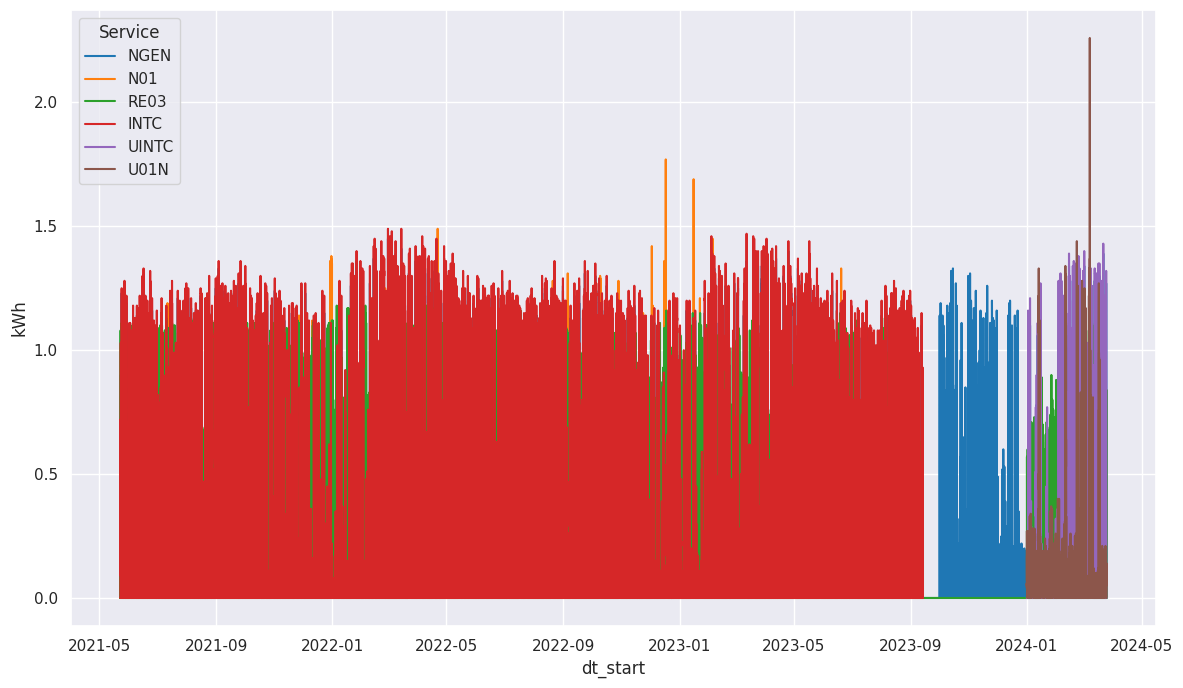

In [26]:

source = df_solar_data

# alt.Chart(source).mark_line().encode(
#     x='dt_start:T',
#     y='kWh:Q',
#     color='Service:N',
# )

sns.set_theme(style="whitegrid")
sns.set_theme(rc={'figure.figsize':(14,8)})

sns.lineplot(data=source, palette="tab10", x='dt_start', y='kWh', hue='Service')  #linewidth=2.5)